## Subir a github

In [8]:
!git clone https://github.com/DMGrana2/mlds_6.git

Cloning into 'mlds_6'...
Updating files:   3% (24/610)
Updating files:   4% (25/610)
Updating files:   4% (27/610)
Updating files:   5% (31/610)
Updating files:   5% (32/610)
Updating files:   6% (37/610)
Updating files:   7% (43/610)
Updating files:   7% (47/610)
Updating files:   8% (49/610)
Updating files:   9% (55/610)
Updating files:  10% (61/610)
Updating files:  10% (63/610)
Updating files:  11% (68/610)
Updating files:  12% (74/610)
Updating files:  12% (78/610)
Updating files:  13% (80/610)
Updating files:  14% (86/610)
Updating files:  15% (92/610)
Updating files:  15% (96/610)
Updating files:  16% (98/610)
Updating files:  17% (104/610)
Updating files:  17% (107/610)
Updating files:  18% (110/610)
Updating files:  19% (116/610)
Updating files:  19% (121/610)
Updating files:  20% (122/610)
Updating files:  21% (129/610)
Updating files:  21% (131/610)
Updating files:  22% (135/610)
Updating files:  23% (141/610)
Updating files:  23% (142/610)
Updating files:  24% (147/610)
Upd

In [ ]:
!mv Analisis_exploratorio.ipynb mlds_6/scripts/eda/

In [ ]:
import os
os.chdir("mlds_6")

In [ ]:
!pwd
!ls scripts/eda/

In [ ]:
!git config --global user.email "nsotelof@unal.edu.co"
!git config --global user.name "Ivan Sotelo"

!git add scripts/eda/Analisis_exploratorio.ipynb
!git commit -m "Agrega notebook de análisis exploratorio para Fase 2"

## reproyectar todos los Rasters utilizados

In [1]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import os
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [5]:
def reproject_and_resample_raster(
    input_raster_path,
    output_raster_path,
    target_crs="EPSG:32618",
    target_resolution=30,
    resampling_method=Resampling.bilinear
):
    """
    Reproyecta y reescala un archivo ráster a un CRS y resolución deseada.

    Parámetros:
    - input_raster_path: ruta al archivo de entrada (.tif)
    - output_raster_path: ruta de salida (.tif)
    - target_crs: sistema de coordenadas de destino (por defecto UTM zona 18N)
    - target_resolution: resolución deseada en unidades del CRS (ej. 30 m)
    - resampling_method: método de remuestreo (bilinear por defecto)

    Devuelve:
    - ruta del archivo de salida
    """
    try:
        with rasterio.open(input_raster_path) as src:
            if src.crs is None:
                raise ValueError("El ráster de entrada no tiene un sistema de coordenadas definido.")

            # Calcular transformación y dimensiones del ráster reproyectado
            transform, width, height = calculate_default_transform(
                src.crs, target_crs, src.width, src.height, *src.bounds, resolution=target_resolution
            )

            profile = src.profile.copy()
            profile.update({
                'crs': target_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rasterio.open(output_raster_path, 'w', **profile) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=target_crs,
                        resampling=resampling_method
                    )
        print(f"✅ Reproyección y remuestreo completados: {output_raster_path}")
        return output_raster_path

    except Exception as e:
        print(f"❌ Error al procesar el ráster: {e}")
        return None

In [215]:
#Usa Resampling.nearest si vas a reprocesar datos categóricos como geología o uso del suelo.

#Usa Resampling.bilinear o cubic para datos continuos como NDVI, pendiente, precipitación.

reproject_and_resample_raster(
    input_raster_path=r"C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\dem_srtm_30m.tif",
    output_raster_path=r"C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\dem2_srtm_30m.tif",
    target_crs="EPSG:32618",
    target_resolution=30,
    resampling_method=Resampling.bilinear  # o .nearest para datos categóricos
)

✅ Reproyección y remuestreo completados: C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\dem2_srtm_30m.tif


'C:\\Users\\Lenovo\\Documents\\Diplomado_ML\\Hackaton\\Reescalamiento\\dem2_srtm_30m.tif'

## Stack multibanda

In [62]:
def crear_stack_multibanda(directorio, salida_stack):
    """
    Detecta todos los archivos .tif en un directorio y genera un stack multibanda.
    
    Parámetros:
    - directorio: ruta a la carpeta donde están los .tif
    - salida_stack: nombre del archivo .tif multibanda a guardar

    Resultado:
    - Guarda un archivo .tif multibanda con todos los rásters alineados
    """
    # Detectar archivos .tif en el directorio
    raster_files = sorted([
        os.path.join(directorio, f)
        for f in os.listdir(directorio)
        if f.lower().endswith(".tif")
    ])

    if not raster_files:
        raise FileNotFoundError("No se encontraron archivos .tif en el directorio.")

    print(f"Se encontraron {len(raster_files)} archivos .tif. Apilando...")

    # Leer metadatos base del primer ráster
    with rasterio.open(raster_files[0]) as src_ref:
        meta = src_ref.meta.copy()
        height, width = src_ref.height, src_ref.width
        dtype = src_ref.dtypes[0]
        crs = src_ref.crs
        transform = src_ref.transform

    # Actualizar metadatos para el stack
    meta.update({
        "count": len(raster_files),
        "dtype": dtype,
        "height": height,
        "width": width,
        "crs": crs,
        "transform": transform
    })

    # Crear el archivo de salida multibanda
    with rasterio.open(salida_stack, "w", **meta) as dst:
        for i, path in enumerate(raster_files, start=1):
            with rasterio.open(path) as src:
                band = src.read(1)
                dst.write(band, i)

    print(f"✅ Stack multibanda guardado como: {salida_stack}")
    return salida_stack

In [219]:
directorio_rasters = r"C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m"
salida = os.path.join(directorio_rasters, "stack_landslide_def.tif")

crear_stack_multibanda(directorio_rasters, salida)

Se encontraron 8 archivos .tif. Apilando...
✅ Stack multibanda guardado como: C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m\stack_landslide_def.tif


'C:\\Users\\Lenovo\\Documents\\Diplomado_ML\\Hackaton\\Reescalamiento\\30m\\stack_landslide_def.tif'

## Extraccion de imagenes

In [225]:
from rasterio.windows import Window
import pandas as pd

# --- Parámetros ---
stack_path = "C:/Users/Lenovo/Documents/Diplomado_ML/Hackaton/Reescalamiento/30m/stack_landslide_def.tif"
puntos_csv = "C:/Users/Lenovo/Documents/Diplomado_ML/Hackaton/puntos_reproyectados_epsg32618.csv"
ventana = 13  # Tamaño de ventana (13x13 píxeles)
mitad = ventana // 2

# --- Leer puntos ---
df_puntos = pd.read_csv(puntos_csv)

# --- Inicializar listas para cubos y etiquetas ---
cubos = []
etiquetas = []

In [227]:
# --- Abrir stack multibanda ---
with rasterio.open(stack_path) as src:
    for _, row in df_puntos.iterrows():
        x, y, etiqueta = row["x"], row["y"], row["deslizamiento"]

        try:
            # Convertir coordenada a índice de píxel
            col, row_idx = src.index(x, y)

            # Definir ventana alrededor del píxel
            ventana_raster = Window(col - mitad, row_idx - mitad, ventana, ventana)

            # Verificar que la ventana esté dentro de los límites
            if (col - mitad < 0 or row_idx - mitad < 0 or
                col + mitad >= src.width or row_idx + mitad >= src.height):
                continue  # saltar bordes

            # Leer el cubo multibanda
            cube = src.read(window=ventana_raster)  # (bands, rows, cols)
            cube = np.transpose(cube, (1, 2, 0))     # (rows, cols, bands)

            # Agregar a la lista
            cubos.append(cube)
            etiquetas.append(etiqueta)

        except Exception as e:
            print(f"Error con punto ({x}, {y}): {e}")
            continue

In [228]:
# --- Convertir a arrays ---
X = np.array(cubos, dtype=np.float32)
y = np.array(etiquetas, dtype=np.uint8)

# --- Guardar en archivos .npy ---
np.save("X_cubos2.npy", X)
np.save("y_etiquetas2.npy", y)

X.shape, y.shape

((851, 13, 13, 8), (851,))

In [231]:
# Rutas de guardado
ruta_guardado = r"C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m"  # ← cambia esto si es necesario
os.makedirs(ruta_guardado, exist_ok=True)

# Asignar nombres de archivo
ruta_X = os.path.join(ruta_guardado, "X_cubos2.npy")
ruta_y = os.path.join(ruta_guardado, "y_etiquetas2.npy")

# Guardar arrays
np.save(ruta_X, X)
np.save(ruta_y, y)

print("✅ Datos guardados en:")
print(" -", ruta_X)
print(" -", ruta_y)

✅ Datos guardados en:
 - C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m\X_cubos2.npy
 - C:\Users\Lenovo\Documents\Diplomado_ML\Hackaton\Reescalamiento\30m\y_etiquetas2.npy


## Explorar datos

In [233]:
import seaborn as sns

# Cargar los archivos .npy
X = np.load("X_cubos2.npy")
y = np.load("y_etiquetas2.npy")

# --- 1. Distribución de clases ---
def plot_class_distribution(y):
    labels, counts = np.unique(y, return_counts=True)
    plt.bar(labels, counts, tick_label=["No Deslizamiento", "Deslizamiento"], color=["skyblue", "salmon"])
    plt.title("Distribución de clases")
    plt.ylabel("Cantidad de muestras")
    plt.show()

# --- 2. Estadísticas por banda ---
def plot_band_statistics_sampled(X, sample_frac=0.05, bins=100):
    num_bands = X.shape[-1]
    fig, axes = plt.subplots(1, num_bands, figsize=(22, 3))

    total_pixels = X.shape[0] * X.shape[1] * X.shape[2]
    sample_size = int(total_pixels * sample_frac)

    for i in range(num_bands):
        data = X[:, :, :, i].flatten()
        sample = np.random.choice(data, size=sample_size, replace=False)
        axes[i].hist(sample, bins=bins, color='cornflowerblue')
        axes[i].set_title(f'Banda {i+1}')
        axes[i].set_xlabel("Valor")
    plt.tight_layout()
    plt.show()

# --- 3. Ejemplos aleatorios por clase ---
def plot_sample_cubes(X, y, num_samples=3):
    classes = [0, 1]
    for label in classes:
        idx = np.where(y == label)[0]
        selected = np.random.choice(idx, num_samples, replace=False)
        fig, axes = plt.subplots(1, num_samples, figsize=(10, 3))
        fig.suptitle(f"Ejemplos de la clase {label}")
        for i, ax in enumerate(axes):
            img = X[selected[i], :, :, :3]  # Mostrar RGB
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Normalizar para visualización
            ax.imshow(img)
            ax.axis('off')
        plt.show()


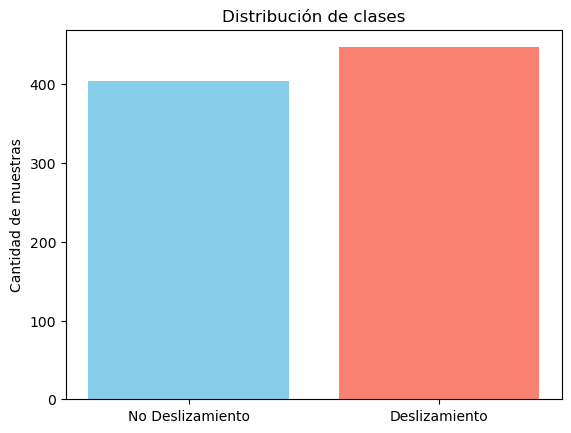

In [235]:
# Ejecutar funciones de análisis
plot_class_distribution(y)

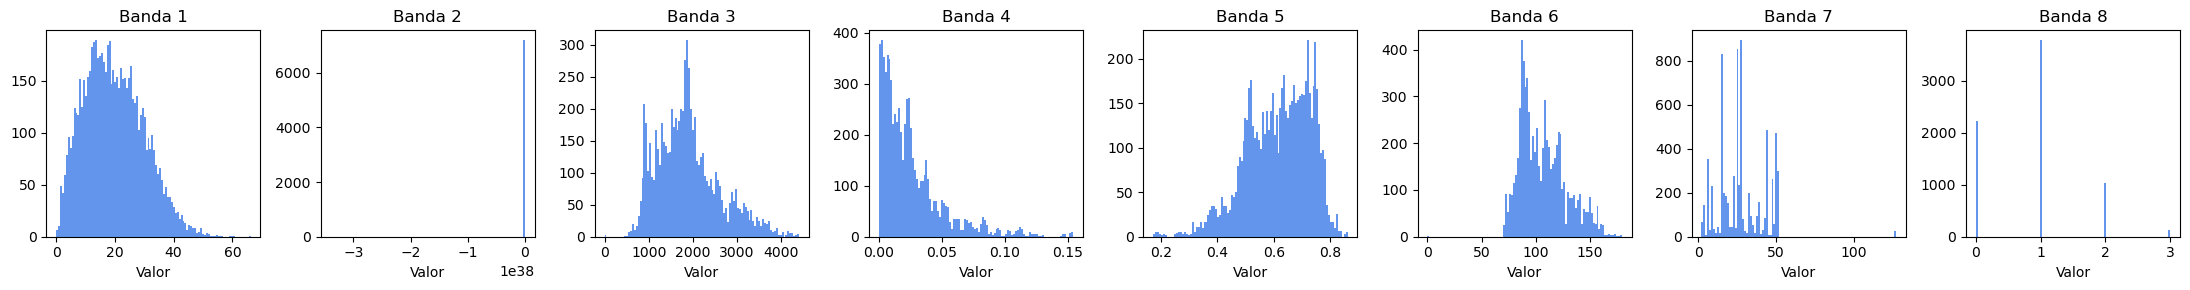

In [237]:
plot_band_statistics_sampled(X, sample_frac=0.05)

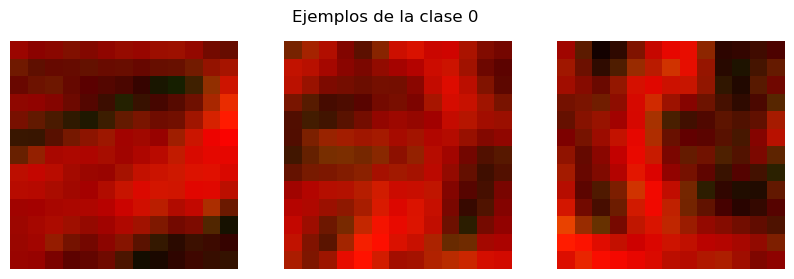

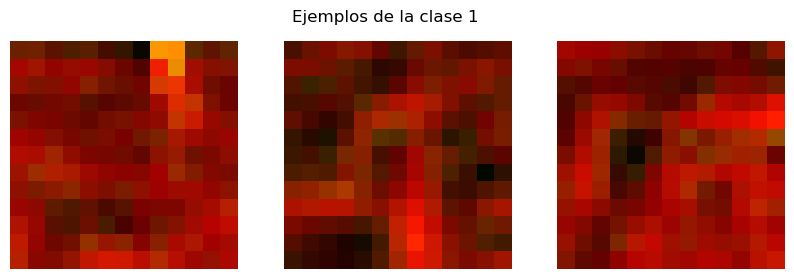

In [188]:
plot_sample_cubes(X, y)

✅ Observaciones clave:
Distribución de clases balanceada:

Hay aproximadamente la misma cantidad de muestras etiquetadas como deslizamiento (1) y no deslizamiento (0).

✅ Esto es bueno porque evita un sesgo del modelo hacia una clase dominante.

Problema en la Banda 2:

Su histograma muestra un pico extremadamente elevado en valores anómalos, probablemente debido a valores nulos, NaN, infinitos o un error de escala (valores cercanos a ±1e36).

⚠️ Esto puede causar que el modelo no aprenda correctamente, ya que los valores anómalos dominan el rango dinámico.

Variabilidad de escalas:

Algunas bandas tienen valores muy pequeños (por ejemplo, banda 3 y banda 4) mientras que otras (como la 5 o la 6) tienen valores entre 0 y 1, y otras son discretas (como la banda 7 con valores muy puntuales).

Esto sugiere que normalizar o estandarizar por banda sería una estrategia necesaria para mejorar el rendimiento.


Forma de X: (851, 13, 13, 8)
Forma de y: (851,)


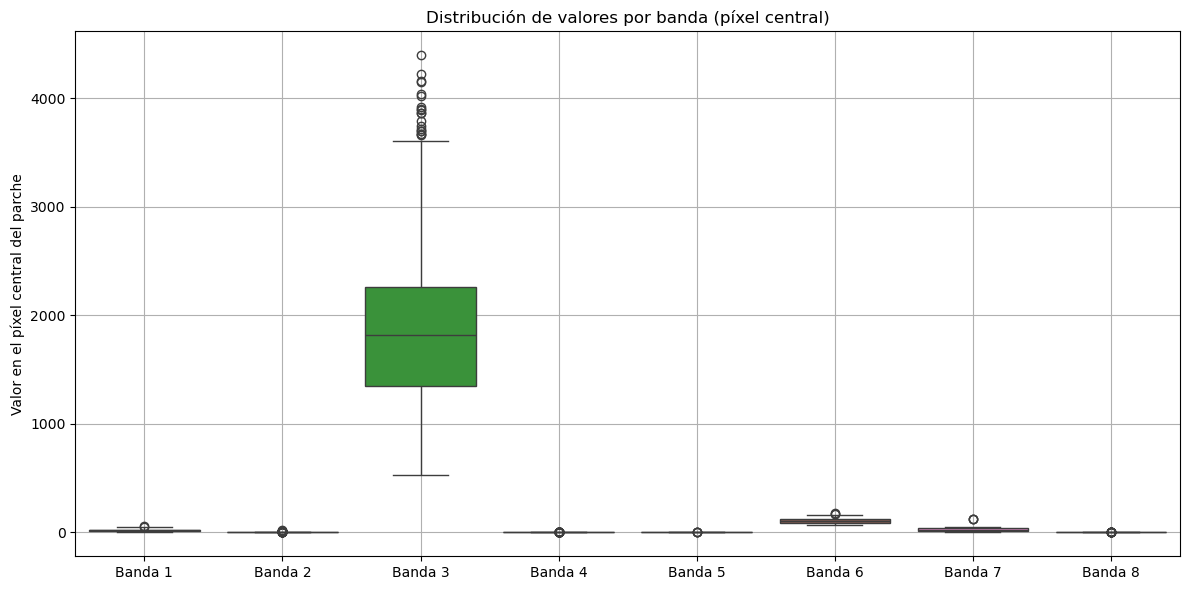

In [239]:
# Cargar los datos
X = np.load("X_cubos2.npy")
y = np.load("y_etiquetas2.npy")

# Verificar dimensiones
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

# Crear boxplots por banda en el centro del parche
num_bandas = X.shape[-1]
valores_centro = []

for i in range(num_bandas):
    valores_banda = X[:, X.shape[1]//2, X.shape[2]//2, i]
    valores_centro.append(valores_banda)

# Plotear boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=valores_centro)
plt.xticks(ticks=range(num_bandas), labels=[f"Banda {i+1}" for i in range(num_bandas)])
plt.ylabel("Valor en el píxel central del parche")
plt.title("Distribución de valores por banda (píxel central)")
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusión:
- Las bandas 1, 5 y 6 claramente aportan información relevante.

- La banda 2 muestra poca variabilidad y puede evaluarse si mejora las métricas.

- Las bandas 3 y 4 son muy planas, lo que sugiere que no aportan y podrían estar afectando negativamente el aprendizaje del modelo.

- La banda 7 está en el límite: si representa una variable categórica (como geología), podrías transformarla (one-hot, ordinal, etc.) o dejarla, pero conviene evaluarla.

In [245]:
ruta_stack = "C:/Users/Lenovo/Documents/Diplomado_ML/Hackaton/Reescalamiento/30m/stack_landslide_def.tif"

with rasterio.open(ruta_stack) as src:
    print(f"🗂️ Número de bandas: {src.count}")
    for i in range(1, src.count + 1):
        band = src.read(i)
        print(f"Banda {i} - min: {band.min()}, max: {band.max()}, dtype: {band.dtype}")

🗂️ Número de bandas: 8
Banda 1 - min: 0.0, max: 84.12029266357422, dtype: float32
Banda 2 - min: -3.4028230607370965e+38, max: 259.73077392578125, dtype: float32
Banda 3 - min: 0.0, max: 5287.0, dtype: float32
Banda 4 - min: 0.0, max: 0.16296102106571198, dtype: float32
Banda 5 - min: -0.026500258594751358, max: 0.8685486316680908, dtype: float32
Banda 6 - min: 0.0, max: 233.87876892089844, dtype: float32
Banda 7 - min: 1.0, max: 127.0, dtype: float32
Banda 8 - min: 0.0, max: 3.0, dtype: float32


| Banda | Rango observado (min–max) | Variable original               | Justificación                                                                                                 |
| ----- | ------------------------- | ------------------------------- | ------------------------------------------------------------------------------------------------------------- |
| 1     | 0.0 – 84.12               | **Pendiente**     | Coincide con el rango \[0.34 – 80.98]                                                                         |
| 2     | -3.4e+38 – 259.73 🛑      | **TRI** ⚠️           | Debería estar en \[0 – 195.83], pero hay valores anómalos, posiblemente píxeles nulos sin filtrar (`no data`) |
| 3     | 0.0 – 5800               | **DEM**                             | 
| 4     | 0.0 – 0.162               | **Distancia a fallas**          | Coincide con el rango \[0 – 0.162]                                                                            |
| 5     | -0.026 – 0.868            | **NDVI**    | Coincide con el rango \[–0.025 – 0.867]                                                                       |
| 6     | 0.0 – 233.87              | **Precipitación** | Coincide con el máximo de 233.87 mm                                                                           |
| 7     | 1 – 127                   | **Geología** | Compatible con codificación categórica (1 a 51) con valores nulos o errores en algunos píxeles                |
| 8     | 0 – 3                     | **TWI clasificado**             | Claramente coincide con la variable clasificada de 3 clases                                                   |


## Normalilzar

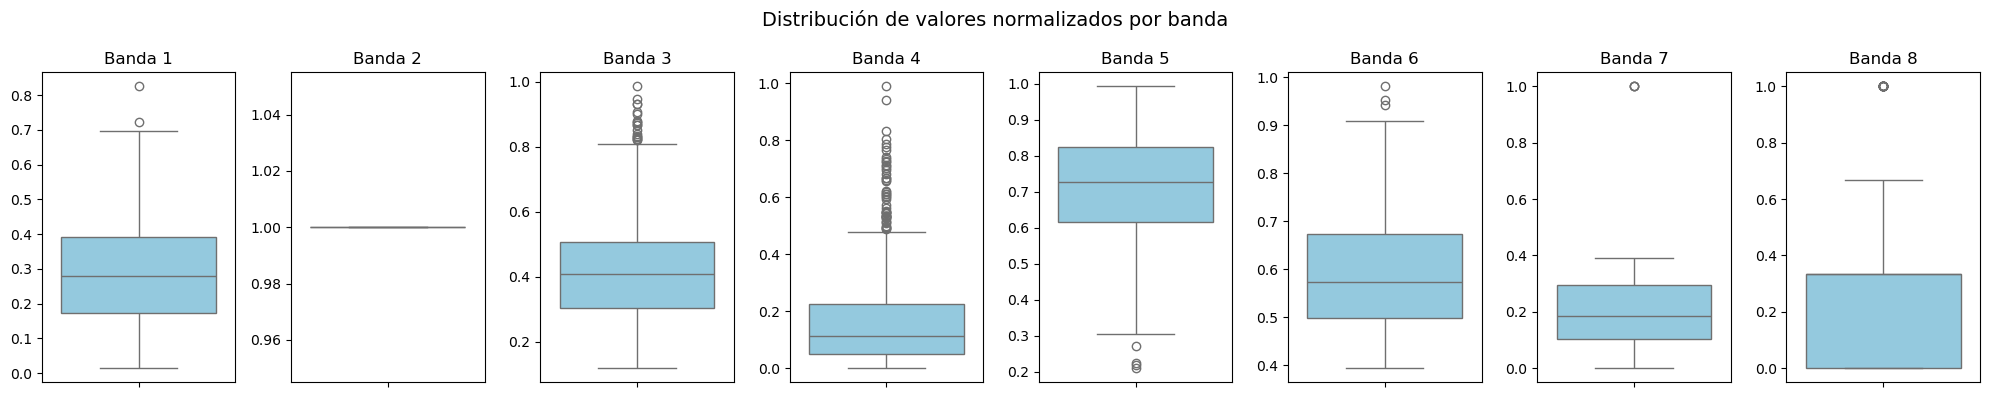

In [247]:
# Normalización min-max por banda
x_norm = np.empty_like(X, dtype=np.float32)
for b in range(X.shape[-1]):
    band = X[:, :, :, b]
    min_val = band.min()
    max_val = band.max()
    x_norm[:, :, :, b] = (band - min_val) / (max_val - min_val + 1e-8)

# Análisis gráfico por banda normalizada
fig, axes = plt.subplots(1, X.shape[-1], figsize=(20, 4))
fig.suptitle("Distribución de valores normalizados por banda", fontsize=14)

for b in range(X.shape[-1]):
    centro_patch = x_norm[:, X.shape[1]//2, X.shape[2]//2, b]
    sns.boxplot(y=centro_patch, ax=axes[b], color='skyblue')
    axes[b].set_title(f'Banda {b+1}')
    axes[b].set_ylabel('')

plt.tight_layout()
plt.show()

Conclusiones por banda:

- Banda 1: Distribución adecuada con variabilidad. ✔️ Útil.

- Banda 2: Todos los valores están en 1.0 (distribución constante). ⚠️ No aporta información útil → deberías descartarla.

- Banda 3: Distribución sesgada pero con variabilidad. ✔️ Útil.

- Banda 4: Distribución amplia y diferenciada. ✔️ Útil.

- Banda 5: Distribución normalizada razonable. ✔️ Útil.

- Banda 6: Algunos valores muy extremos, pero conserva dispersión. ✔️ Útil (con precaución).

- Banda 7: Buena variabilidad, útil. ✔️

In [116]:
# Configuración de la validación cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

In [118]:
# Definir función para crear el modelo
def crear_modelo():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(13, 13, 7)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [122]:
# Entrenamiento con validación cruzada
for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), 1):
    print(f"\n📦 Entrenando Fold {fold}...")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = crear_modelo()

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=100,
                        batch_size=32,
                        callbacks=[early_stop],
                        verbose=0)

    # Evaluación
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    acc = accuracy_score(y_val, y_pred)
    print(f"✅ Accuracy Fold {fold}: {acc:.4f}")
    fold_results.append(acc)


📦 Entrenando Fold 1...


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
✅ Accuracy Fold 1: 0.6433

📦 Entrenando Fold 2...


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
✅ Accuracy Fold 2: 0.5529

📦 Entrenando Fold 3...


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
✅ Accuracy Fold 3: 0.4765

📦 Entrenando Fold 4...


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
✅ Accuracy Fold 4: 0.4765

📦 Entrenando Fold 5...


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
✅ Accuracy Fold 5: 0.4765


In [124]:
# Resultados promedio
promedio = np.mean(fold_results)
print(f"\n🎯 Accuracy promedio (5-fold CV): {promedio:.4f}")


🎯 Accuracy promedio (5-fold CV): 0.5251


In [126]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 404, 1: 447}

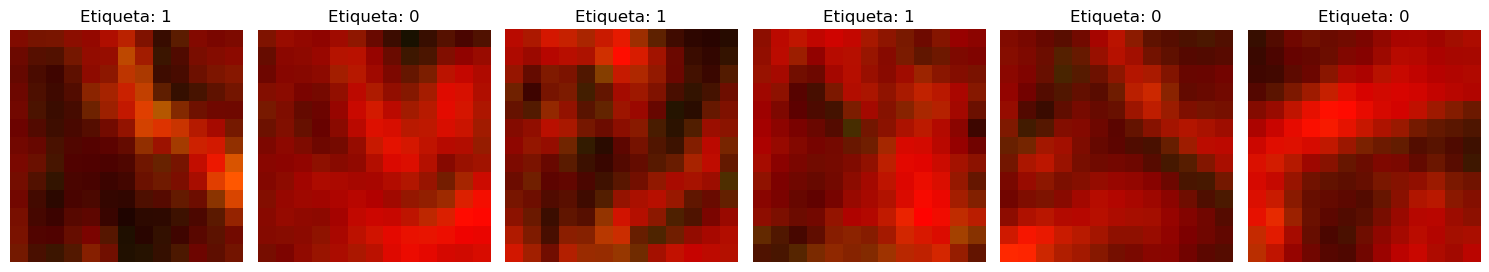

In [128]:
# Visualizar algunos cubos aleatorios
def visualizar_cubos(X, y, num=6):
    indices = np.random.choice(len(X), size=num, replace=False)
    fig, axes = plt.subplots(1, num, figsize=(15, 3))

    for i, idx in enumerate(indices):
        cube = X[idx]
        label = y[idx]

        # Seleccionamos 3 bandas para mostrar como RGB (ejemplo: bandas 0, 1, 2)
        rgb = cube[:, :, :3]
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalizar para visualizar

        axes[i].imshow(rgb)
        axes[i].axis("off")
        axes[i].set_title(f"Etiqueta: {label}")

    plt.tight_layout()
    plt.show()

visualizar_cubos(X, y, num=6)